In [2]:
import tensorflow as tf
from tensorflow.keras import layers

### Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Product Attention
def scaled_dot_product_attention(q, k, v, mask):     #(Q, K, V는 다 4D 텐서: (batch_size, num_heads, seq_len, depth))
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [3]:
### Multi-Head Attention
class MultiHeadAttention(layers.Layer):          #num_head = 헤드개수 <예)8개>
    def __init__(self, d_model, num_heads):        #d_model: 전체 출력 차원 (예: 512)
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)      #여러 head를 만들려면 Q, K, V를 한번 linear transform 해줘야 함. (독립적으로 head들이 일할 수 있도록)
#마지막에 여러 head를 이어붙인 걸 다시 d_model 크기로 맞춰주는 Dense 레이어.
    def split_heads(self, x, batch_size):
      ## 1. (batch_size, seq_len, d_model) → (batch_size, seq_len, num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.num_heads * self.depth))

        output = self.dense(concat_attention)
        return output


   #[입력 Q, K, V]
       #  -> (각각 Dense에 통과)
       #  -> (split_heads로 여러 head로 나눔)
       #  -> (각 head마다 scaled dot-product attention 계산)
       #  -> (head들 concat)
       #  -> (마지막 Dense로 출력)

In [4]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [5]:
### Encoder Layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [6]:
### Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask=mask, training=training)

        return x  # (batch_size, input_seq_len, d_model)

In [7]:
### Transformer Classifier (Main Model)
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding,
                 num_classes=4, rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, rate)
        self.dropout = layers.Dropout(rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        mask = create_padding_mask(inputs)
        x = self.encoder(inputs, mask = mask, training=training)  # (batch_size, seq_len, d_model)
        cls_token = x[:, 0, :]
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)                   # (batch_size, num_classes)

In [9]:
#########################################################################################################################

In [10]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

# 1. 헤더 없는 CSV 로드
df_train = pd.read_csv("twitter_training.csv", header=None)
df_val= pd.read_csv("twitter_training.csv", header=None)
df_train.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
df_val.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
# 2. 필요 없는 열 제거
df_train = df_train.drop(columns=["Tweet ID"])
df_val = df_val.drop(columns=["Tweet ID"])
# 3. 소문자 변환
df_train["Tweet comment"] = df_train["Tweet comment"].astype(str).str.lower()
df_train["Entity"] = df_train["Entity"].astype(str).str.lower()

df_val["Tweet comment"] = df_val["Tweet comment"].astype(str).str.lower()
df_val["Entity"] = df_val["Entity"].astype(str).str.lower()

#결측치 확인
df_train.isnull().sum()
df_val.isnull().sum()

,0
Entity,0
Sentiment,0
Tweet comment,0


In [11]:
# 4. input_text 생성
df_train["input_text"] = df_train.apply(
    lambda x: f"{x['Tweet comment']} [SEP] {x['Entity']}",
    axis=1
)  #[CLS] 문장1 [SEP] 문장2 [SEP]

df_val["input_text"] = df_val.apply(
    lambda x: f"{x['Tweet comment']} [SEP] {x['Entity']}",
    axis=1
)  #[CLS] 문장1 [SEP] 문장2 [SEP]

In [12]:
# 5. 토크나이저 (서브워드 자동 사용)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

encodings_train = tokenizer(
    df_train["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf",
    add_special_tokens=True
)

encodings_val = tokenizer(
    df_val["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf",
    add_special_tokens=True
)

# 6. 라벨 인코딩
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}  #라벨 맵핑

df_train["label"] = df_train["Sentiment"].map(label_map)
labels_train = df_train["label"].values

df_val["label"] = df_val["Sentiment"].map(label_map)
labels_val = df_val["label"].values

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [13]:
example = df_train["input_text"].iloc[0]

print(tokenizer.tokenize(example))
print(tokenizer.encode(example))  # 숫자 토큰


['im', 'getting', 'on', 'border', '##lands', 'and', 'i', 'will', 'murder', 'you', 'all', ',', '[SEP]', 'border', '##lands']
[101, 10047, 2893, 2006, 3675, 8653, 1998, 1045, 2097, 4028, 2017, 2035, 1010, 102, 3675, 8653, 102]


In [14]:
x_train = encodings_train["input_ids"]
x_val = encodings_val["input_ids"]

y_train = labels_train    #정답 레이블
y_val = labels_val        #정답 레이블


y_train = tf.one_hot(y_train, depth=4) #원 핫 인코딩
y_val   = tf.one_hot(y_val, depth=4)  #원 핫 인코딩


batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

In [15]:
print(labels_train[:20])


[2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2]


In [16]:
print(y_val[:20])



tf.Tensor(
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(20, 4), dtype=float32)


In [17]:
print(tf.reduce_sum(y_train, axis=0))  # 각 라벨 개수
print(tf.unique(tf.argmax(y_train, axis=1)))

tf.Tensor([22542. 18318. 20832. 12990.], shape=(4,), dtype=float32)
Unique(y=<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 1, 0, 3])>, idx=<tf.Tensor: shape=(74682,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


In [18]:
num_layers = 2
d_model = 128
num_heads = 4
dff = 256
vocab_size = tokenizer.vocab_size
max_len = 128
num_classes = 4   # negative / neutral / positive / irrelevant

model = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    maximum_position_encoding=max_len,
    num_classes=num_classes,
    rate=0.1
)


In [19]:
optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)



Epoch 1/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.4598 - loss: 1.2254 - val_accuracy: 0.7410 - val_loss: 0.6892
Epoch 2/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7268 - loss: 0.7106 - val_accuracy: 0.8628 - val_loss: 0.3786
Epoch 3/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8321 - loss: 0.4517 - val_accuracy: 0.9035 - val_loss: 0.2602
Epoch 4/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8731 - loss: 0.3408 - val_accuracy: 0.9260 - val_loss: 0.1970
Epoch 5/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9002 - loss: 0.2677 - val_accuracy: 0.9371 - val_loss: 0.1632
Epoch 6/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9145 - loss: 0.2289 - val_accuracy: 0.9482 - val_loss: 0.1337
Epoch 7/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9262 - loss: 0.1953 - val_accuracy: 0.9515 - val_loss: 0.1207
Epoch 8/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.9332 -

In [21]:
model.build(input_shape=(None, max_len))
model.summary()


Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     4,171,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,516,878 (47.75 MB)

 Trainable params: 4,172,292 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,344,586 (31.83 MB)

In [22]:
y_pred = model.predict(val_ds)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


In [23]:
y_true = labels_val   # 정수 라벨 (원핫 아님!!!11)


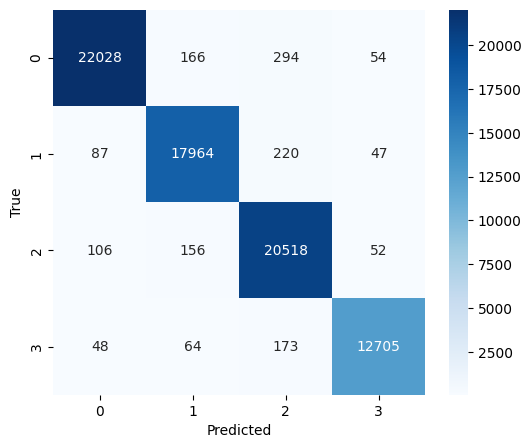

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


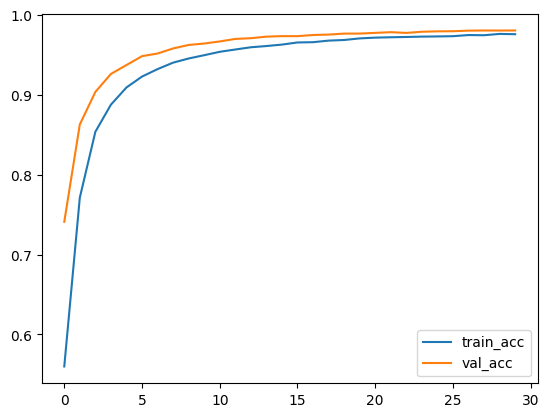

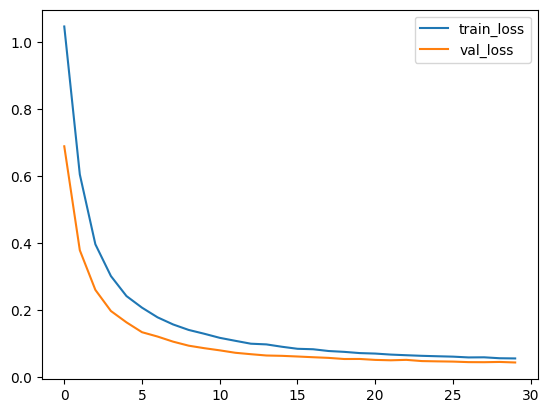

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [26]:
import numpy as np
import tensorflow as tf

def preprocess_sentence(sentence, entity, tokenizer, max_len=128):   #직접 문장 넣어서 확인해보기
    sentence = sentence.lower()
    entity = entity.lower()

    combined = "[CLS] " + sentence + " [SEP] " + entity

    encoded = tokenizer(
        combined,
        add_special_tokens=False,   #직접 CLS/SEP 넣었으니까
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )["input_ids"]

    return encoded  # (1, max_len)


def predict_sentiment(model, sentence, entity, tokenizer, max_len=128):
    x = preprocess_sentence(sentence, entity, tokenizer, max_len)

    preds = model.predict(x)
    label_id = np.argmax(preds)

    id2label = {
        0: "negative",
        1: "neutral",
        2: "positive",
        3: "irrelevant"
    }

    return id2label[label_id], preds



# ============================
# 테스트 실행
# ============================

sentence = "so i spent a few hours doing something for fun... if you don't know i'm a huge @ borderlands fan and maya is one of my favorite characters."
entity = "borderlands"

label, raw = predict_sentiment(model, sentence, entity, tokenizer)

print("예측 라벨:", label)
print("raw:", raw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
예측 라벨: positive
raw: [[1.8139744e-06 9.3239487e-06 9.9991560e-01 7.3251649e-05]]


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 모델 예측
y_pred_probs = model.predict(val_ds)
y_pred_labels = y_pred_probs.argmax(axis=1)

# 각 지표 계산
precision = precision_score(y_true, y_pred_labels, average='macro')
recall    = recall_score(y_true, y_pred_labels,   average='macro')
f1        = f1_score(y_true, y_pred_labels,       average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# 클래스별 상세 보고서
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred_labels))


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Precision: 0.9809612830933843
Recall: 0.9802149866843989
F1-score: 0.9805532000106407

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     22542
           1       0.98      0.98      0.98     18318
           2       0.97      0.98      0.98     20832
           3       0.99      0.98      0.98     12990

    accuracy                           0.98     74682
   macro avg       0.98      0.98      0.98     74682
weighted avg       0.98      0.98      0.98     74682

